# Example: Modeling Based on System/Stack Ratings

This example demonstrates the use of `calc_rated_system` to test electrolyzer system configurations. Given a baseline electrolyzer definition, this tool will tune parameters such that the overall system matches a desired system rating.

For a given baseline electrolyzer stack, and desired system rating, the function implements the following procedure:

- determine a number of stacks by dividing the system rating by baseline stack rating
- tune stack parameters to achieve a stack rating that matches the desired system rating when multiplied by the number of stacks
    - modify number of cells to get close to desired stack rating
    - solve for the residual power rating by modifying cell area
    
This approach is intended to allow for smooth scaling of electrolyzer system sizes for hybrid system optimization without modifying electrolyzer configurations beyond acceptable values.


In [1]:
import pprint
import copy

import numpy as np
import matplotlib.pyplot as plt

from electrolyzer import run_electrolyzer, run_lcoh
from electrolyzer.inputs import validation as val
from electrolyzer.glue_code.optimization import calc_rated_system

## Model Creation

In [2]:
fname_input_modeling = "./modeling_options.yaml"
modeling_options = val.load_modeling_yaml(fname_input_modeling)
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(modeling_options)

{   'electrolyzer': {   'cell_params': {   'ALK_params': {   'electrode': {   'A_electrode': 300,
                                                                              'd_ac': 0.25,
                                                                              'd_am': 0.125,
                                                                              'd_cm': 0.125,
                                                                              'e_a': 0.2,
                                                                              'e_c': 0.2},
                                                             'electrolyte': {   'w_koh': 30},
                                                             'membrane': {   'A_membrane': 300,
                                                                             'e_m': 0.05},
                                                             'model': 'default_hri',
                                                             'pressure_operat

In [3]:
def plot_systems(models):
    """Plot a series of configured systems."""
    fig, axes = plt.subplots(5, 1, figsize=(6, 8))
    fig.tight_layout()

    # n_cells = [m["electrolyzer"]["stack"]["n_cells"] for m in models]
    # cell_area = [m["electrolyzer"]["stack"]["cell_area"] for m in models]
    # stack_rating = [m["electrolyzer"]["stack"]["stack_rating_kW"] for m in models]
    # n_stacks = [m["electrolyzer"]["control"]["n_stacks"] for m in models]
    # system_ratings = [m["electrolyzer"]["control"]["system_rating_MW"] for m in models]

    n_cells = [m["electrolyzer"]["stack"]["n_cells"] for m in models]
    cell_area = [m["electrolyzer"]["cell_params"]["PEM_params"]["cell_area"] for m in models]
    max_current = [m["electrolyzer"]["stack"]["max_current"] for m in models]
    stack_rating = [m["electrolyzer"]["stack"]["stack_rating_kW"] for m in models]
    n_stacks = [m["electrolyzer"]["supervisor"]["n_stacks"] for m in models]
    system_ratings = [m["electrolyzer"]["supervisor"]["system_rating_MW"] for m in models]

    axes[0].plot(system_ratings, n_cells)
    axes[0].set_ylabel("Cell Count")
    axes[0].set_title("Model Configurations")

    axes[1].plot(system_ratings, cell_area)
    axes[1].set_ylabel("Cell Area ($cm^2$)")
    
    axes[2].plot(system_ratings, max_current)
    axes[2].set_ylabel("Max Current ($A$)")

    axes[3].plot(system_ratings, n_stacks)
    axes[3].set_ylabel("Stack Count")

    axes[4].plot(system_ratings, stack_rating)
    axes[4].set_ylabel("Stack Rating (kW)")
    axes[4].set_xlabel("System Rating (MW)")

In [4]:
def build_models(system_ratings, modeling_options):
    models = []
    options = copy.deepcopy(modeling_options)

    for sys_rating in system_ratings:
        options["electrolyzer"]["supervisor"]["system_rating_MW"] = sys_rating
        options_tuned = calc_rated_system(options)
        models.append(options_tuned)

    return models


#### Baseline Case

This case shows the system configuration when stacks are tuned to a value that evenly divides desired system rating.

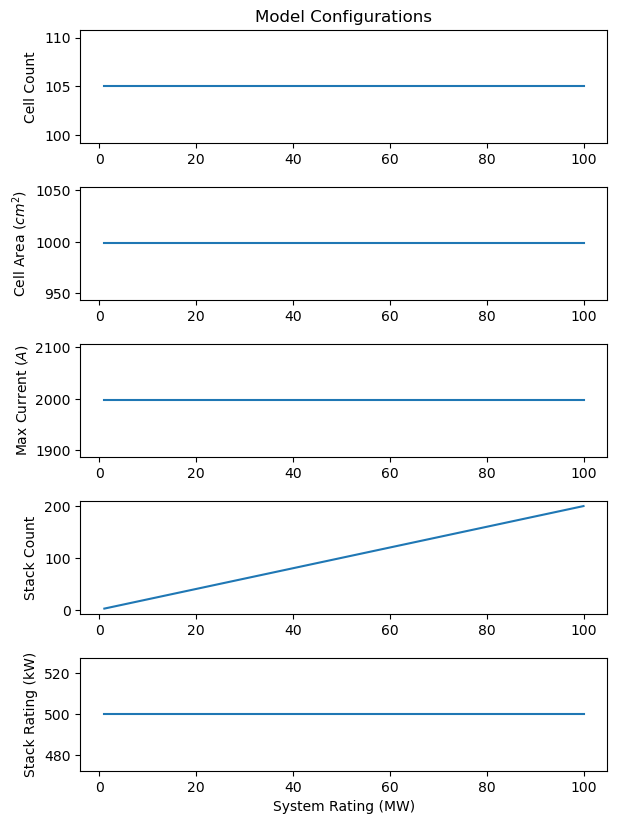

In [5]:
system_ratings = np.linspace(1.0, 100, 100) # divides evenly
models = build_models(system_ratings, modeling_options)

plot_systems(models)

#### Another Case

In this case, the stacks need more tuning to match the desired system rating. However, these changes show the same general behavior as the baseline case.

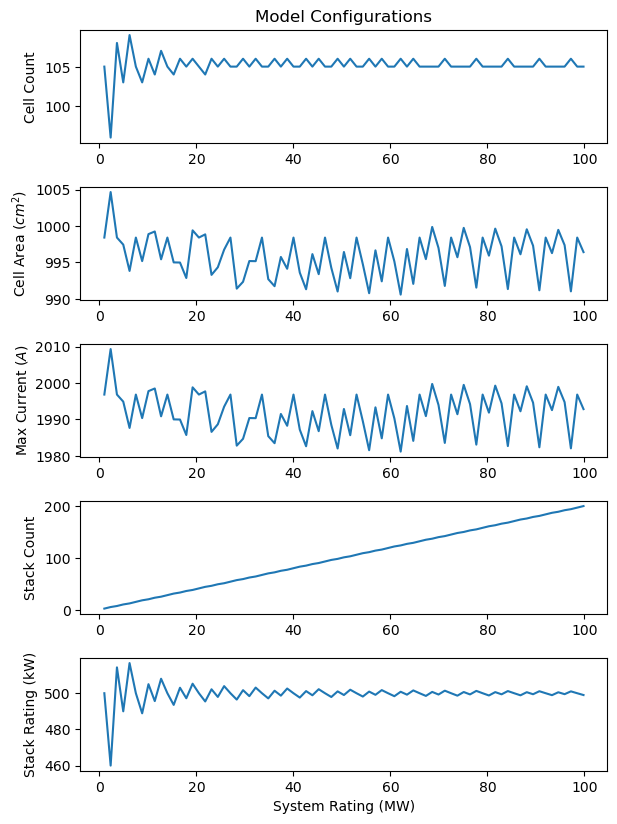

In [6]:
# divides unevenly
system_ratings_uneven = np.arange(1.0, 100, 1.3)

models_uneven = build_models(system_ratings_uneven, modeling_options)

plot_systems(models_uneven)

## Running Models for H2 Production

Run the models and compare H2 production based on test power signals. The power signals are set to match the electrolyzer system rated power for each simulation.

In [7]:
def create_power_signal(rating):
    """Create cosine test signal from rating (MW)."""
    test_signal_angle = np.linspace(0, 8 * np.pi, 3600 * 8 + 10)
    base_value = (rating / 2) + 0.2
    variation_value = rating - base_value
    power_test_signal = (base_value + variation_value * np.cos(test_signal_angle)) * 1e6
    
    return power_test_signal

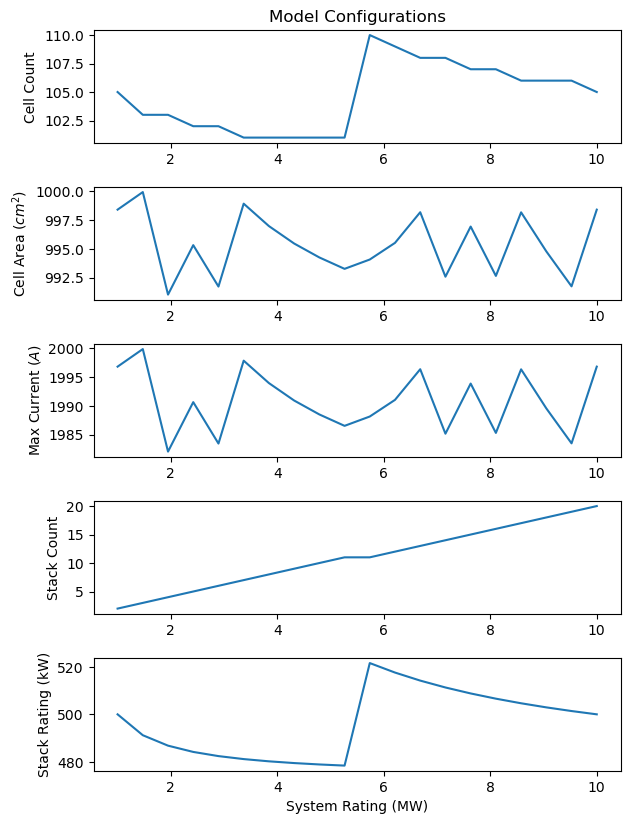

In [8]:
system_ratings = np.linspace(1.0, 10, 20)

models = build_models(system_ratings, modeling_options)

plot_systems(models)

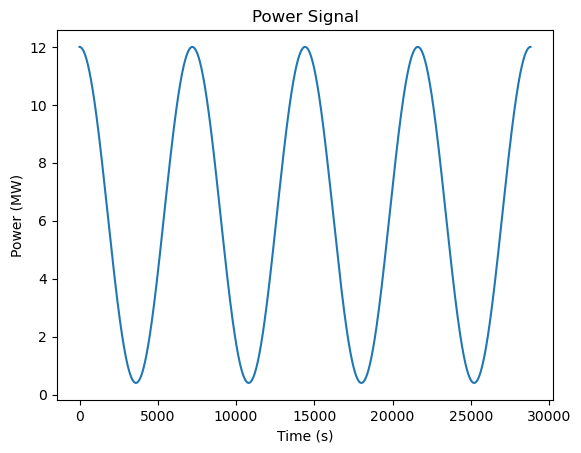

In [9]:
ax = plt.subplot(xlabel="Time (s)", ylabel="Power (MW)")
ax.set_title("Power Signal")
ax.plot(create_power_signal(12.0) / 1e6)

In [10]:
h2_results = []

for m in models:
    sys_rating = m["electrolyzer"]["supervisor"]["system_rating_MW"]
    print("Running for System size: ", sys_rating)
    power_test_signal = create_power_signal(sys_rating)
    _, res = run_electrolyzer(m, power_test_signal)
    h2_results.append(res)


Running for System size:  1.0


Running for System size:  1.4736842105263157
Running for System size:  1.9473684210526314
Running for System size:  2.4210526315789473
Running for System size:  2.894736842105263
Running for System size:  3.3684210526315788
Running for System size:  3.8421052631578947
Running for System size:  4.315789473684211
Running for System size:  4.789473684210526
Running for System size:  5.263157894736842
Running for System size:  5.7368421052631575
Running for System size:  6.2105263157894735
Running for System size:  6.684210526315789
Running for System size:  7.157894736842105
Running for System size:  7.63157894736842
Running for System size:  8.105263157894736
Running for System size:  8.578947368421051
Running for System size:  9.052631578947368
Running for System size:  9.526315789473683
Running for System size:  10.0


In [ ]:
h2_prod = [r["kg_rate"].sum() for r in h2_results]
h2_rates = [r["kg_rate"] for r in h2_results]

Text(0, 0.5, '$H_2$ Produced (kg)')

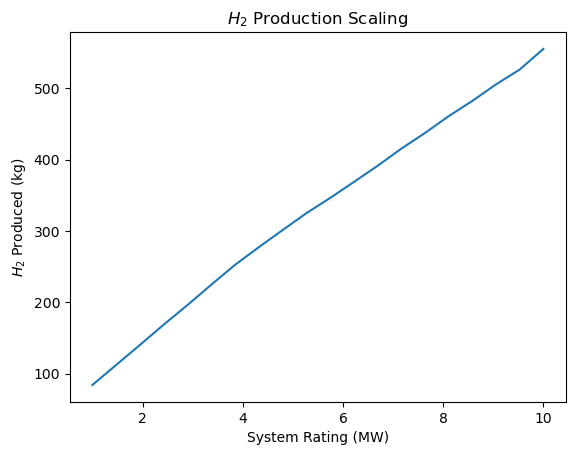

In [ ]:
fig, ax = plt.subplots()

ax.plot(system_ratings, h2_prod)
ax.set_xlabel("System Rating (MW)")
ax.set_title("$H_2$ Production Scaling")
ax.set_ylabel("$H_2$ Produced (kg)")

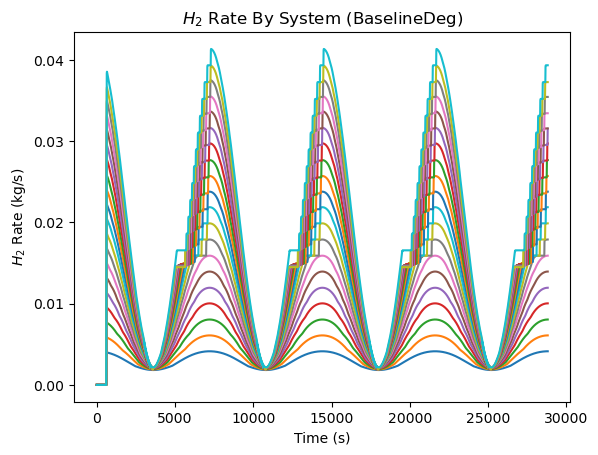

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Time (s)")
ax.set_ylabel("$H_2$ Rate (kg/s)")
control_type = modeling_options["electrolyzer"]["controller"]["control_type"]
ax.set_title(f"$H_2$ Rate By System ({control_type})")

for r in h2_rates:
    ax.plot(h2_results[0].index, r)

## Alternate form: `run_electrolyzer` using `optimize=True`

This approach will perform the same run as `run_electrolyzer` above, but improves efficiency by only keeping track of necessary metrics for optimization.

In [ ]:
h2_results_opt = []
curr_density_results = []

for sys_rating in system_ratings:
    options = copy.deepcopy(modeling_options)
    options["electrolyzer"]["supervisor"]["system_rating_MW"] = sys_rating
    print("Running for System size: ", sys_rating)
    power_test_signal = create_power_signal(sys_rating)
    h2, curr_density = run_electrolyzer(options, power_test_signal, optimize=True)
    h2_results_opt.append(h2)
    curr_density_results.append(curr_density)

In [ ]:
ax = plt.subplot()
ax.plot(system_ratings, h2_results_opt)
ax.set_title("$H_2$ Production Scaling")
ax.set_xlabel("System Rating (MW)")
ax.set_ylabel("$H_2$ Produced (kg)")

In [ ]:
ax = plt.subplot()
ax.plot(system_ratings, curr_density_results)
ax.set_xlabel("System Rating (MW)")
ax.set_ylabel("Current Density (A/$cm^2$)")
ax.set_title("Maximum Current Density")
ax.set_ylim(0, 2.5)

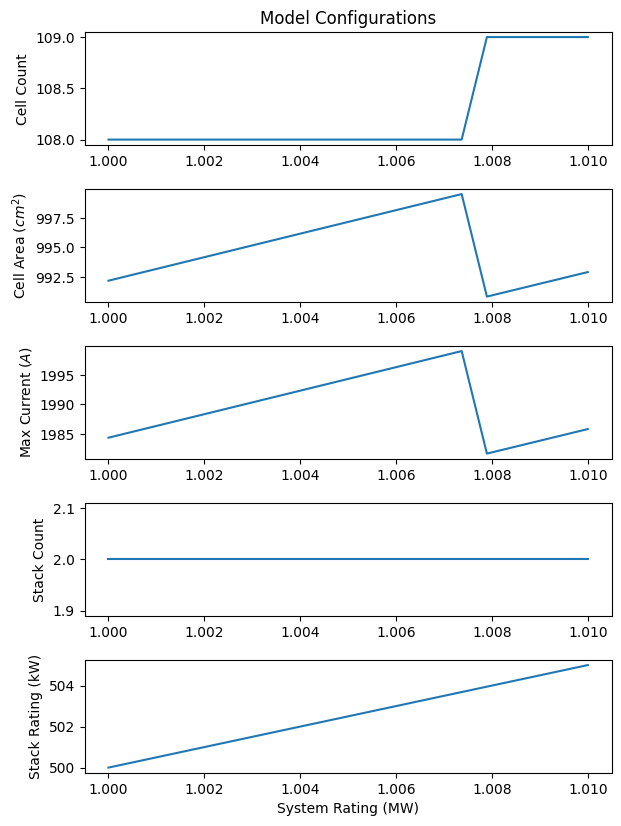

In [ ]:
system_ratings = np.linspace(1.0, 1.01, 20)

models = build_models(system_ratings, modeling_options)

plot_systems(models)

In [ ]:
h2_results_opt = []

for sys_rating in system_ratings:
    options = copy.deepcopy(modeling_options)
    options["electrolyzer"]["control"]["system_rating_MW"] = sys_rating
    print("Running for System size: ", sys_rating)
    power_test_signal = create_power_signal(sys_rating)
    h2, curr_density = run_electrolyzer(options, power_test_signal, optimize=True)
    h2_results_opt.append(h2)


Running for System size:  1.0
Running for System size:  1.0005263157894737
Running for System size:  1.0010526315789474
Running for System size:  1.0015789473684211
Running for System size:  1.0021052631578948
Running for System size:  1.0026315789473683
Running for System size:  1.003157894736842
Running for System size:  1.0036842105263157
Running for System size:  1.0042105263157894
Running for System size:  1.0047368421052632
Running for System size:  1.0052631578947369
Running for System size:  1.0057894736842106
Running for System size:  1.0063157894736843
Running for System size:  1.006842105263158
Running for System size:  1.0073684210526317
Running for System size:  1.0078947368421052
Running for System size:  1.0084210526315789
Running for System size:  1.0089473684210526
Running for System size:  1.0094736842105263
Running for System size:  1.01


Text(0, 0.5, '$H_2$ Produced (kg)')

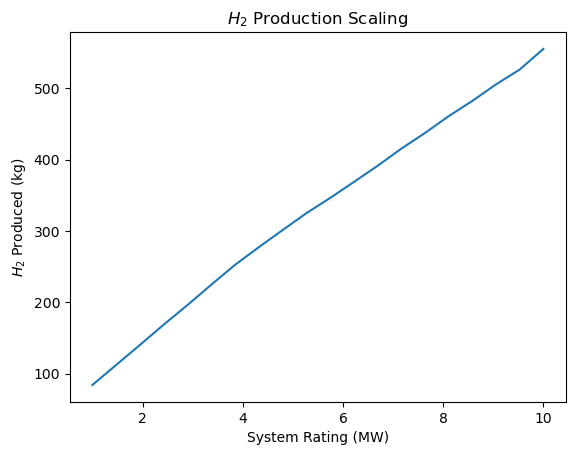

In [ ]:
ax = plt.subplot()
ax.plot(system_ratings, h2_results_opt)
ax.set_title("$H_2$ Production Scaling")
ax.set_xlabel("System Rating (MW)")
ax.set_ylabel("$H_2$ Produced (kg)")

(0.0, 2.5)

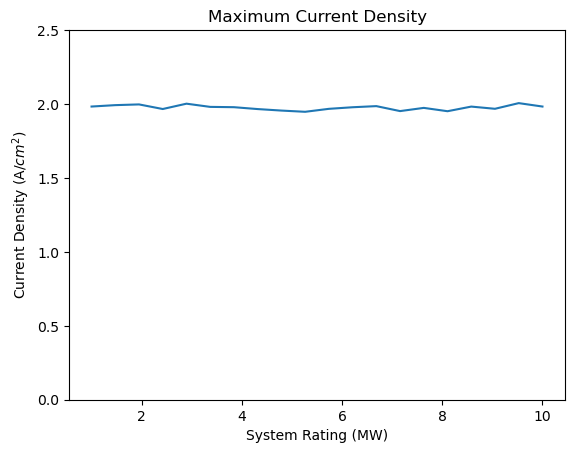

In [ ]:
ax = plt.subplot()
ax.plot(system_ratings, curr_density_results)
ax.set_xlabel("System Rating (MW)")
ax.set_ylabel("Current Density (A/$cm^2$)")
ax.set_title("Maximum Current Density")
ax.set_ylim(0, 2.5)